# Pipeline End-to-End Klasifikasi Machine Learning


## Pendahuluan
Notebook ini menunjukkan proses end-to-end untuk klasifikasi machine learning menggunakan dataset kartu kredit. Dataset ini berisi 30 fitur (V1-V28, Time, Amount) dan 1 target (Class) yang menunjukkan apakah transaksi termasuk fraud (1) atau normal (0).


## Pengumpulan & Pembersihan Data

### Impor Library yang Diperlukan


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')

### Membaca dan Memeriksa Dataset


In [3]:
# Membaca data dari file CSV
df = pd.read_csv('KlasifikasiUTS.csv')

# Melihat 5 data teratas
print("Data teratas:")
print(df.head())

# Informasi dataset
print("\nInformasi dataset:")
print(df.info())

# Statistik deskriptif
print("\nStatistik deskriptif:")
print(df.describe())

# Memeriksa nilai yang hilang
print("\nJumlah nilai yang hilang per kolom:")
print(df.isnull().sum())

# Memeriksa jumlah data per kelas
print("\nDistribusi kelas:")
print(df['Class'].value_counts())
print(f"Persentase kelas 0: {df['Class'].value_counts()[0]/len(df)*100:.2f}%")
print(f"Persentase kelas 1: {df['Class'].value_counts()[1]/len(df)*100:.2f}%")

Data teratas:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       

### Visualisasi Distribusi Kelas

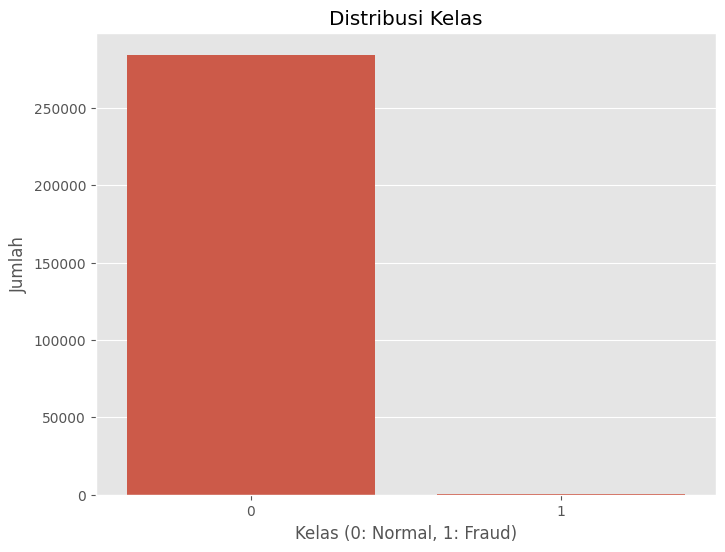

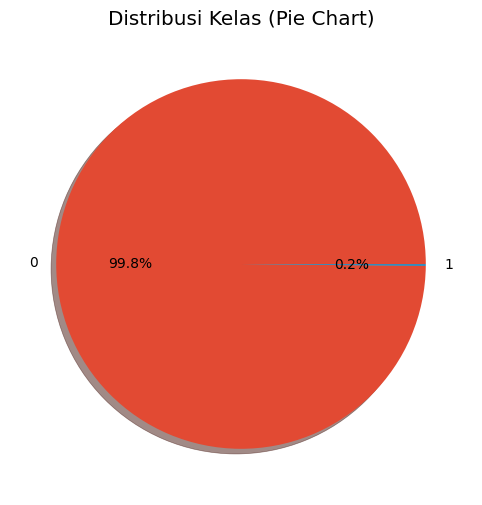

In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Class')
plt.title('Distribusi Kelas')
plt.xlabel('Kelas (0: Normal, 1: Fraud)')
plt.ylabel('Jumlah')
plt.show()

# Visualisasi dengan pie chart
plt.figure(figsize=(8, 6))
df['Class'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True)
plt.title('Distribusi Kelas (Pie Chart)')
plt.ylabel('')
plt.show()

### Eksplorasi Fitur

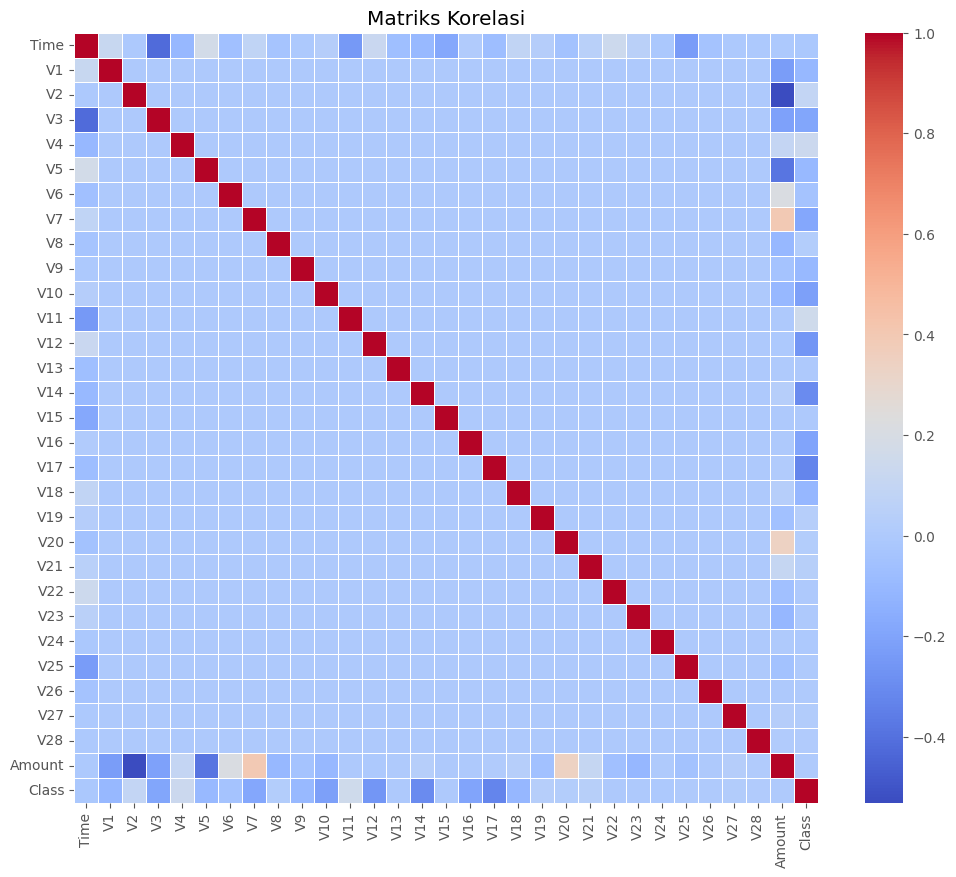

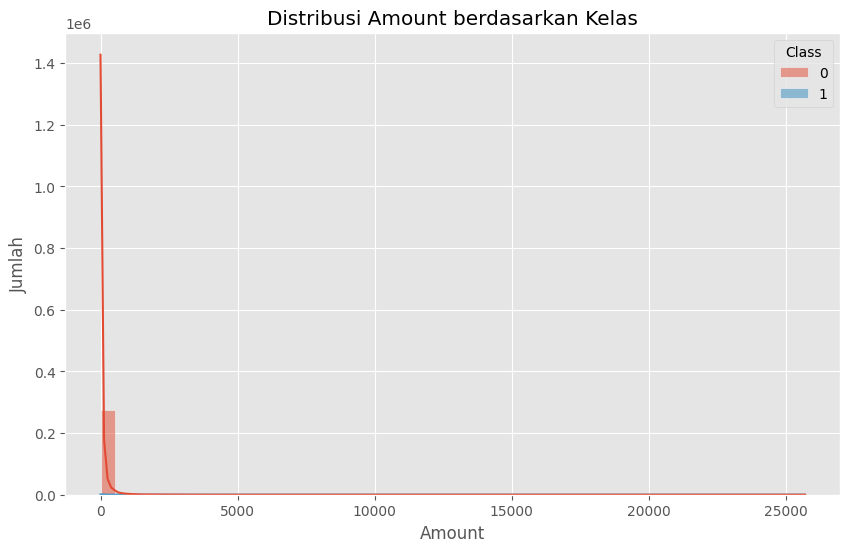

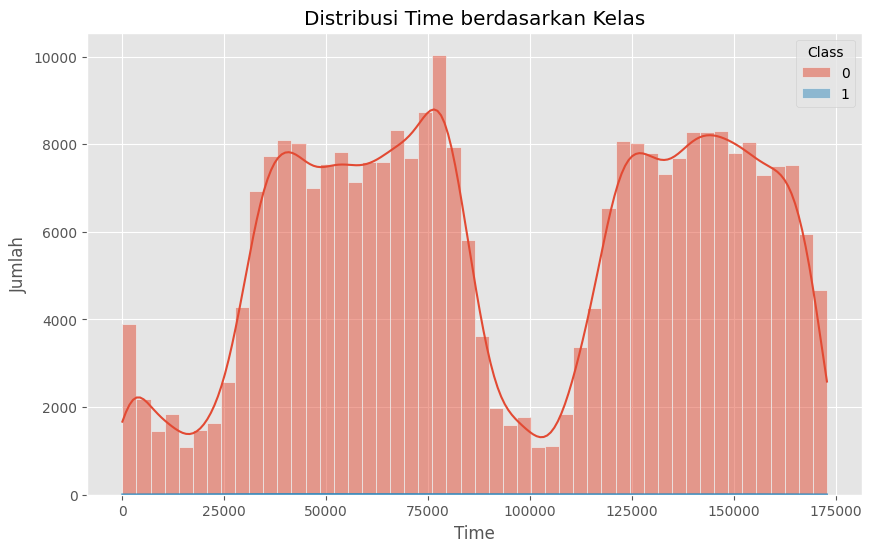

In [5]:
# Melihat korelasi antara fitur
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Matriks Korelasi')
plt.show()

# Distribusi fitur Amount
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Amount', hue='Class', bins=50, kde=True)
plt.title('Distribusi Amount berdasarkan Kelas')
plt.xlabel('Amount')
plt.ylabel('Jumlah')
plt.show()

# Distribusi fitur Time
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Time', hue='Class', bins=50, kde=True)
plt.title('Distribusi Time berdasarkan Kelas')
plt.xlabel('Time')
plt.ylabel('Jumlah')
plt.show()

## Pembersihan Data

In [6]:
# Memisahkan fitur dan target
X = df.drop('Class', axis=1)
y = df['Class']

# Memisahkan data menjadi numerik dan kategorikal (jika ada)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

print(f"Fitur numerik: {len(numeric_features)}")
print(f"Fitur kategorikal: {len(categorical_features)}")

Fitur numerik: 30
Fitur kategorikal: 0


## Feature Selection

### 1. Menghapus Fitur dengan Varians Rendah

In [7]:
# Mendeteksi fitur dengan varians hampir konstan
def identify_quasi_constant_features(X, threshold=0.01):
    """Mengidentifikasi fitur dengan varians rendah"""
    constant_filter = VarianceThreshold(threshold=threshold)
    constant_filter.fit(X)
    constant_columns = [column for column, include in zip(X.columns, constant_filter.get_support()) if not include]
    return constant_columns

quasi_constant_features = identify_quasi_constant_features(X)
print(f"Fitur dengan varians rendah: {quasi_constant_features}")

# Menghapus fitur dengan varians rendah
if quasi_constant_features:
    X = X.drop(quasi_constant_features, axis=1)
    print(f"Jumlah fitur setelah menghapus fitur dengan varians rendah: {X.shape[1]}")
else:
    print("Tidak ada fitur dengan varians rendah")

Fitur dengan varians rendah: []
Tidak ada fitur dengan varians rendah


### 2. Mendeteksi Fitur Duplikat

In [8]:
def identify_duplicated_features(X):
    """Mengidentifikasi fitur duplikat"""
    duplicated = []
    corr_matrix = X.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    duplicated = [column for column in upper_tri.columns if any(upper_tri[column] > 0.98)]
    return duplicated

duplicated_features = identify_duplicated_features(X)
print(f"Fitur duplikat: {duplicated_features}")

# Menghapus fitur duplikat
if duplicated_features:
    X = X.drop(duplicated_features, axis=1)
    print(f"Jumlah fitur setelah menghapus fitur duplikat: {X.shape[1]}")
else:
    print("Tidak ada fitur duplikat")

Fitur duplikat: []
Tidak ada fitur duplikat


### 3. Feature Selection berdasarkan Korelasi dengan Target

Korelasi fitur-fitur dengan target:
     Correlation
V17    -0.326481
V14    -0.302544
V12    -0.260593
V10    -0.216883
V16    -0.196539
V3     -0.192961
V7     -0.187257
V11     0.154876
V4      0.133447
V18    -0.111485


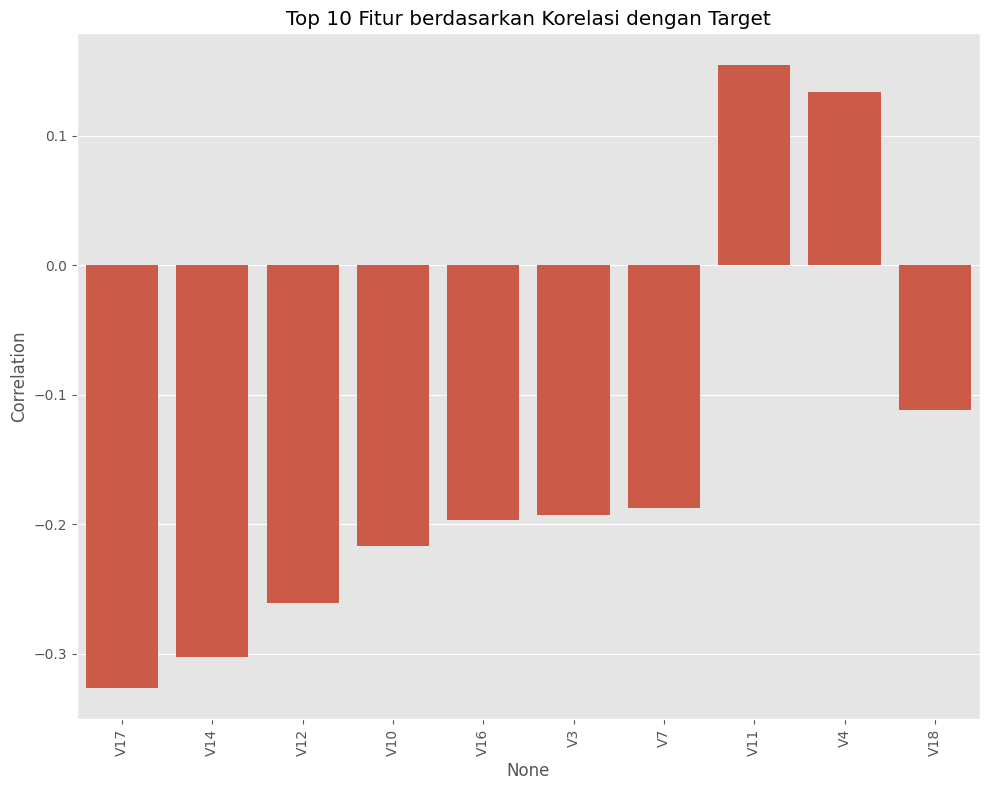

In [9]:
# Korelasi dengan target
correlation_with_target = pd.DataFrame(X.corrwith(y), columns=['Correlation'])
correlation_with_target = correlation_with_target.sort_values(by='Correlation', ascending=False, key=abs)
print("Korelasi fitur-fitur dengan target:")
print(correlation_with_target.head(10))

plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_with_target.index[:10], y='Correlation', data=correlation_with_target.head(10))
plt.title('Top 10 Fitur berdasarkan Korelasi dengan Target')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 4. Feature Selection dengan Mutual Information

Top 15 fitur berdasarkan Mutual Information:
   Feature  MI Score
17     V17  0.008258
14     V14  0.008136
12     V12  0.007601
10     V10  0.007530
11     V11  0.006831
16     V16  0.006144
4       V4  0.004976
3       V3  0.004952
18     V18  0.004317
9       V9  0.004277
7       V7  0.003952
2       V2  0.003228
21     V21  0.002452
27     V27  0.002444
5       V5  0.002389


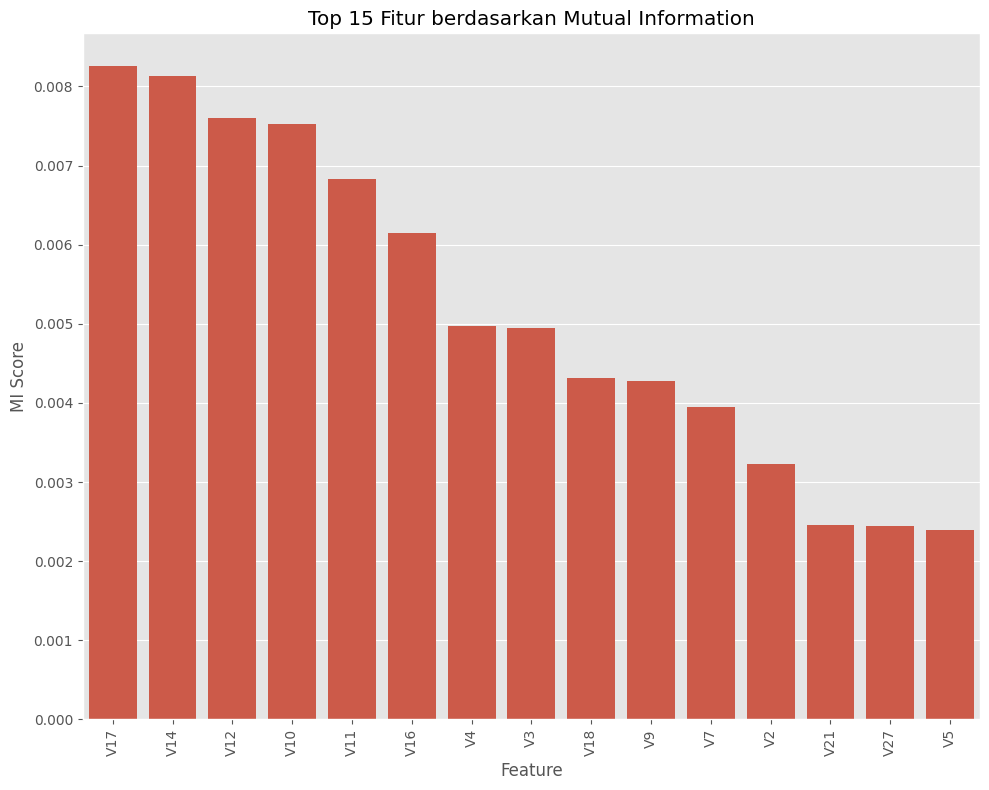

In [10]:
def mutual_information_selection(X, y, k=10):
    """Seleksi fitur menggunakan Mutual Information"""
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()]
    mi_scores = pd.DataFrame({
        'Feature': X.columns,
        'MI Score': selector.scores_
    }).sort_values(by='MI Score', ascending=False)
    return selected_features, mi_scores

# Menerapkan Mutual Information
selected_mi_features, mi_scores = mutual_information_selection(X, y, k=15)
print("Top 15 fitur berdasarkan Mutual Information:")
print(mi_scores.head(15))

plt.figure(figsize=(10, 8))
sns.barplot(x='Feature', y='MI Score', data=mi_scores.head(15))
plt.title('Top 15 Fitur berdasarkan Mutual Information')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 5. Feature Selection dengan Chi-Square

Top 15 fitur berdasarkan Chi-Square:
   Feature    Chi2 Score
0     Time  1.028609e+06
29  Amount  6.396301e+03
4       V4  1.789061e+03
11     V11  1.483577e+03
14     V14  1.246726e+03
12     V12  1.033516e+03
17     V17  8.702947e+02
10     V10  6.459636e+02
16     V16  5.978161e+02
3       V3  5.044926e+02
7       V7  3.508877e+02
18     V18  2.618113e+02
9       V9  2.444139e+02
1       V1  1.989622e+02
2       V2  8.900427e+01


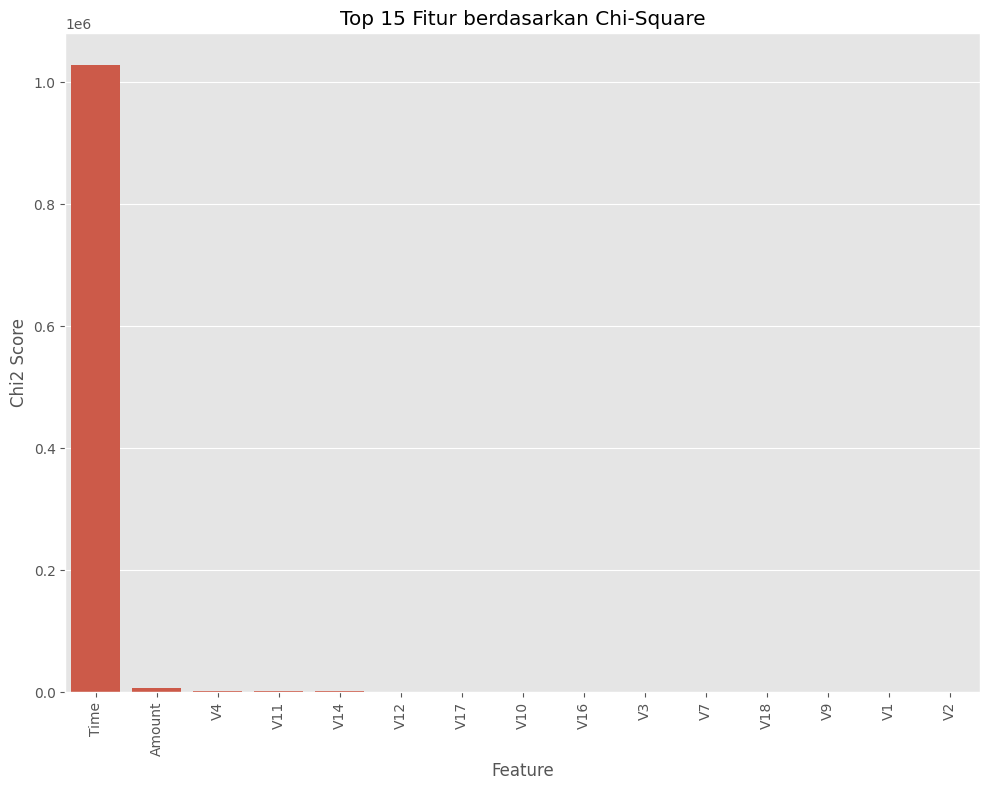

In [11]:
def chi_square_selection(X, y, k=10):
    """Seleksi fitur menggunakan Chi-Square (hanya untuk data non-negatif)"""
    # Memastikan semua nilai non-negatif
    X_non_negative = X.copy()
    for col in X_non_negative.columns:
        if X_non_negative[col].min() < 0:
            X_non_negative[col] = X_non_negative[col] - X_non_negative[col].min()

    selector = SelectKBest(chi2, k=k)
    selector.fit(X_non_negative, y)
    selected_features = X.columns[selector.get_support()]
    chi2_scores = pd.DataFrame({
        'Feature': X.columns,
        'Chi2 Score': selector.scores_
    }).sort_values(by='Chi2 Score', ascending=False)
    return selected_features, chi2_scores

# Menerapkan Chi-Square
selected_chi2_features, chi2_scores = chi_square_selection(X, y, k=15)
print("Top 15 fitur berdasarkan Chi-Square:")
print(chi2_scores.head(15))

plt.figure(figsize=(10, 8))
sns.barplot(x='Feature', y='Chi2 Score', data=chi2_scores.head(15))
plt.title('Top 15 Fitur berdasarkan Chi-Square')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 6. Feature Selection dengan ANOVA F-test

Top 15 fitur berdasarkan ANOVA F-test:
   Feature  ANOVA F-Score
17     V17   33979.168593
14     V14   28695.547788
12     V12   20749.822361
10     V10   14057.979985
16     V16   11443.349428
3       V3   11014.508305
7       V7   10349.605408
11     V11    6999.355047
4       V4    5163.832114
18     V18    3584.380605
1       V1    2955.668946
9       V9    2746.600273
5       V5    2592.357929
2       V2    2393.401678
6       V6     543.510578


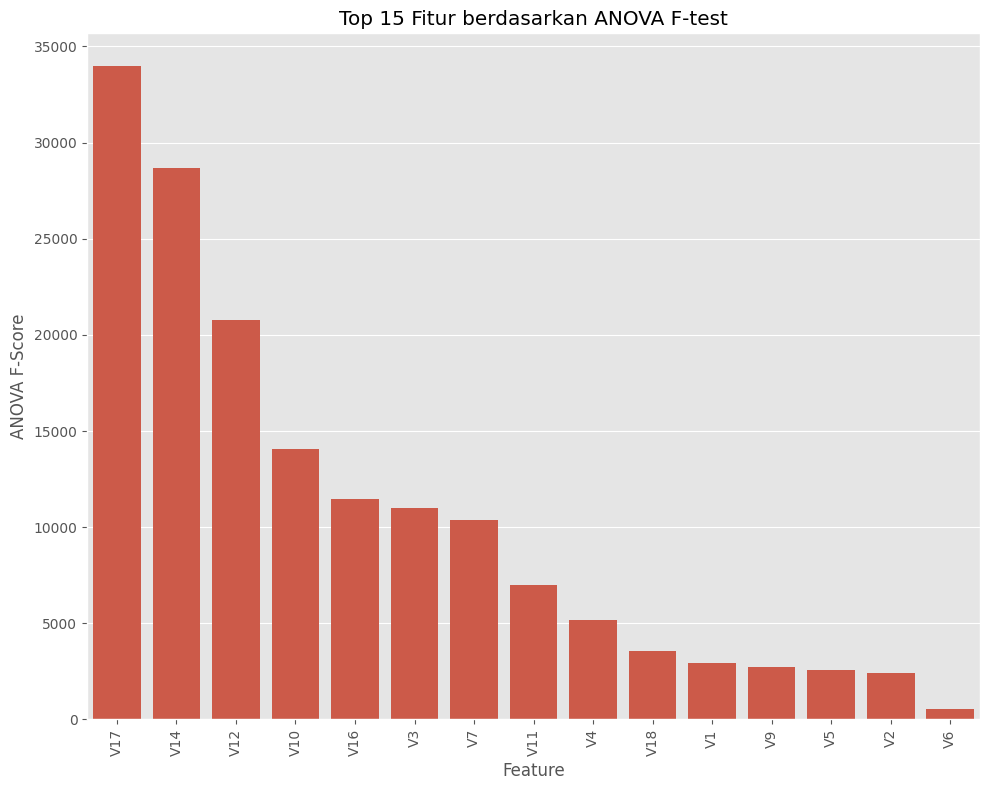

In [12]:
def anova_selection(X, y, k=10):
    """Seleksi fitur menggunakan ANOVA F-test"""
    selector = SelectKBest(f_classif, k=k)
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()]
    anova_scores = pd.DataFrame({
        'Feature': X.columns,
        'ANOVA F-Score': selector.scores_
    }).sort_values(by='ANOVA F-Score', ascending=False)
    return selected_features, anova_scores

# Menerapkan ANOVA
selected_anova_features, anova_scores = anova_selection(X, y, k=15)
print("Top 15 fitur berdasarkan ANOVA F-test:")
print(anova_scores.head(15))

plt.figure(figsize=(10, 8))
sns.barplot(x='Feature', y='ANOVA F-Score', data=anova_scores.head(15))
plt.title('Top 15 Fitur berdasarkan ANOVA F-test')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 7. Menggabungkan Hasil Feature Selection

In [13]:
# Mengambil fitur yang muncul di ketiga metode
common_features = list(set(selected_mi_features) & set(selected_chi2_features) & set(selected_anova_features))
print(f"Fitur yang muncul di ketiga metode: {common_features}")
print(f"Jumlah fitur yang dipilih: {len(common_features)}")

# Jika ada fitur tambahan yang ingin dimasukkan
additional_features = ['Amount', 'Time']  # Contoh fitur tambahan
final_features = list(set(common_features + additional_features))
print(f"Fitur akhir yang digunakan: {final_features}")
print(f"Jumlah fitur akhir: {len(final_features)}")

# Membuat dataset dengan fitur terpilih
X_selected = X[final_features]

Fitur yang muncul di ketiga metode: ['V16', 'V14', 'V2', 'V9', 'V4', 'V10', 'V7', 'V17', 'V18', 'V3', 'V11', 'V12']
Jumlah fitur yang dipilih: 12
Fitur akhir yang digunakan: ['V16', 'V14', 'Amount', 'Time', 'V2', 'V9', 'V4', 'V10', 'V7', 'V17', 'V18', 'V3', 'V11', 'V12']
Jumlah fitur akhir: 14


## Feature Engineering

### 1. Standarisasi Fitur Numerik


In [14]:
# Standarisasi untuk fitur numerik
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_selected), columns=X_selected.columns)

# Melihat hasil standarisasi
print("Hasil standarisasi:")
print(X_scaled.describe())

Hasil standarisasi:
                V16           V14        Amount          Time            V2  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.836189e-17  2.594615e-17  2.913952e-17 -3.065637e-16 -9.580116e-18   
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min   -1.612534e+01 -2.004428e+01 -3.532294e-01 -1.996583e+00 -4.403529e+01   
25%   -5.341353e-01 -4.439565e-01 -3.308401e-01 -8.552120e-01 -3.624707e-01   
50%    7.579255e-02  5.278702e-02 -2.652715e-01 -2.131453e-01  3.965683e-02   
75%    5.971989e-01  5.144513e-01 -4.471707e-02  9.372174e-01  4.867202e-01   
max    1.976044e+01  1.098147e+01  1.023622e+02  1.642058e+00  1.335775e+01   

                 V9            V4           V10            V7           V17  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   7.234983e-19 -5.189230e-18  5.588401e-18  1.237432e-17  3.392958e-18   
std    1.000002e+00  1.000002e+

### 2. Encoding untuk Fitur Kategorikal

In [15]:
# Jika ada fitur kategorikal, lakukan one-hot encoding
# Dalam dataset ini, semua fitur sudah numerik
print("Tidak ada fitur kategorikal yang perlu di-encode")

Tidak ada fitur kategorikal yang perlu di-encode


### 3. Transformasi Data untuk Mengatasi Ketidakseimbangan Kelas


Distribusi kelas sebelum SMOTE:
Class
0    284315
1       492
Name: count, dtype: int64
Distribusi kelas setelah SMOTE:
Class
0    284315
1    284315
Name: count, dtype: int64


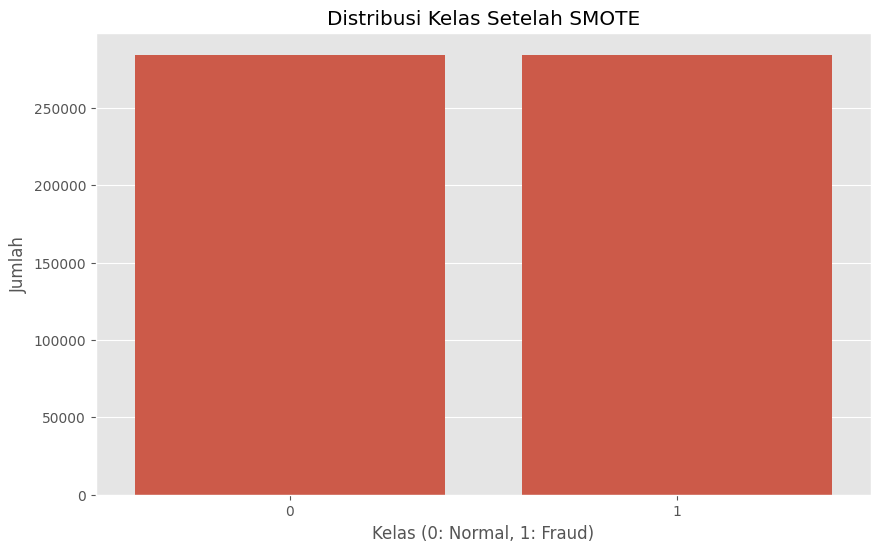

In [16]:
# Cek distribusi kelas
print("Distribusi kelas sebelum SMOTE:")
print(pd.Series(y).value_counts())

# Terapkan SMOTE untuk mengatasi ketidakseimbangan kelas
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Cek distribusi kelas setelah SMOTE
print("Distribusi kelas setelah SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Visualisasi distribusi kelas setelah SMOTE
plt.figure(figsize=(10, 6))
sns.countplot(x=y_resampled)
plt.title('Distribusi Kelas Setelah SMOTE')
plt.xlabel('Kelas (0: Normal, 1: Fraud)')
plt.ylabel('Jumlah')
plt.show()

## Pembagian Data Train dan Test

In [17]:
# Membagi data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print(f"Ukuran X_train: {X_train.shape}")
print(f"Ukuran X_test: {X_test.shape}")
print(f"Distribusi kelas di y_train: {pd.Series(y_train).value_counts()}")
print(f"Distribusi kelas di y_test: {pd.Series(y_test).value_counts()}")

Ukuran X_train: (454904, 14)
Ukuran X_test: (113726, 14)
Distribusi kelas di y_train: Class
0    227452
1    227452
Name: count, dtype: int64
Distribusi kelas di y_test: Class
1    56863
0    56863
Name: count, dtype: int64


## Pemodelan dan Evaluasi

### Fungsi Evaluasi Model

In [18]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Mengevaluasi model dengan berbagai metrik dan menampilkan hasil
    """
    # Melatih model
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Membuat prediksi
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Membuat confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Menampilkan hasil
    print(f"\n--- {model_name} ---")
    print(f"Waktu pelatihan: {train_time:.2f} detik")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Menampilkan classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Visualisasi confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.show()

    # Visualisasi ROC curve dan AUC
    if y_pred_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()

        # Visualisasi Precision-Recall curve
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)
        pr_auc = auc(recall_curve, precision_curve)

        plt.figure(figsize=(8, 6))
        plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
        plt.axhline(y=sum(y_test)/len(y_test), color='red', linestyle='--', label='Baseline')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {model_name}')
        plt.legend(loc="lower left")
        plt.show()

    # Mengembalikan hasil evaluasi
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'train_time': train_time,
        'roc_auc': roc_auc if y_pred_prob is not None else None
    }

    return results

### 1. Logistic Regression


--- Logistic Regression ---
Waktu pelatihan: 1.42 detik
Accuracy: 0.9368
Precision: 0.9727
Recall: 0.8987
F1 Score: 0.9343

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     56863
           1       0.97      0.90      0.93     56863

    accuracy                           0.94    113726
   macro avg       0.94      0.94      0.94    113726
weighted avg       0.94      0.94      0.94    113726



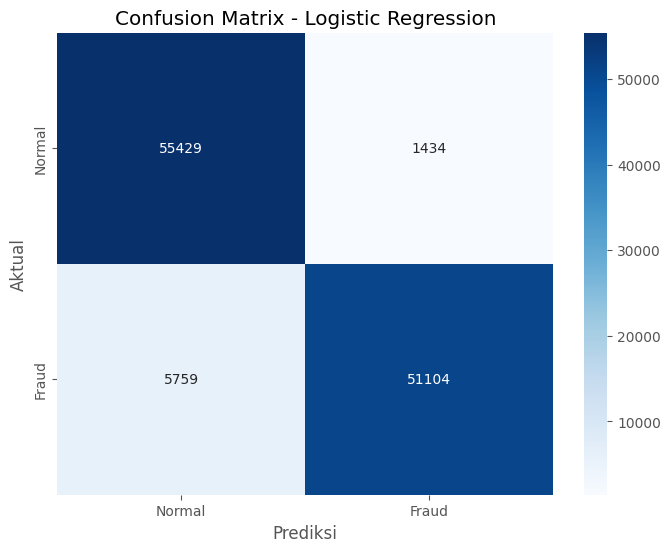

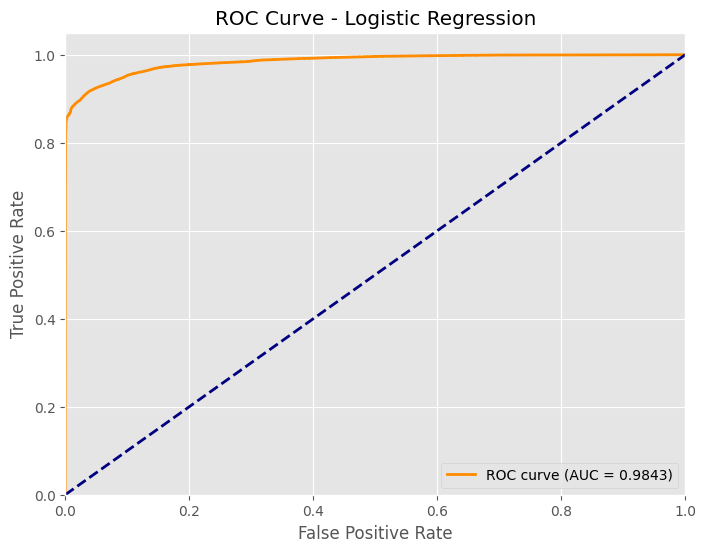

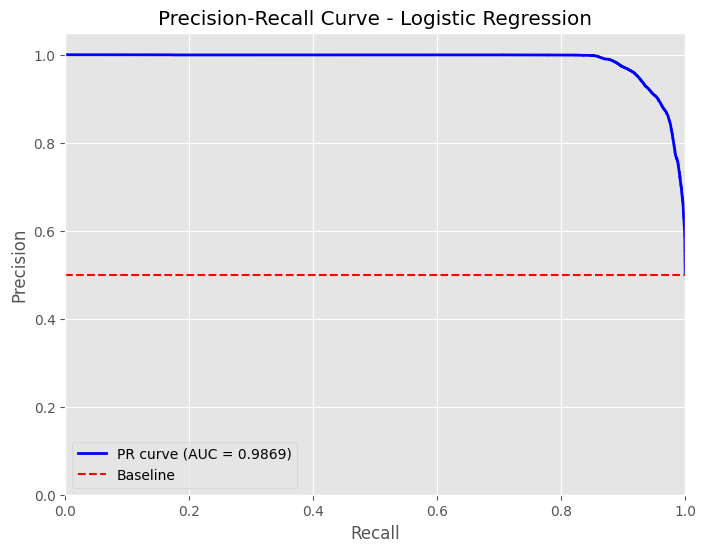

In [19]:
# Membuat model Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg_results = evaluate_model(log_reg, X_train, X_test, y_train, y_test, "Logistic Regression")

### 2. Decision Tree


--- Decision Tree ---
Waktu pelatihan: 26.66 detik
Accuracy: 0.9982
Precision: 0.9978
Recall: 0.9987
F1 Score: 0.9982

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



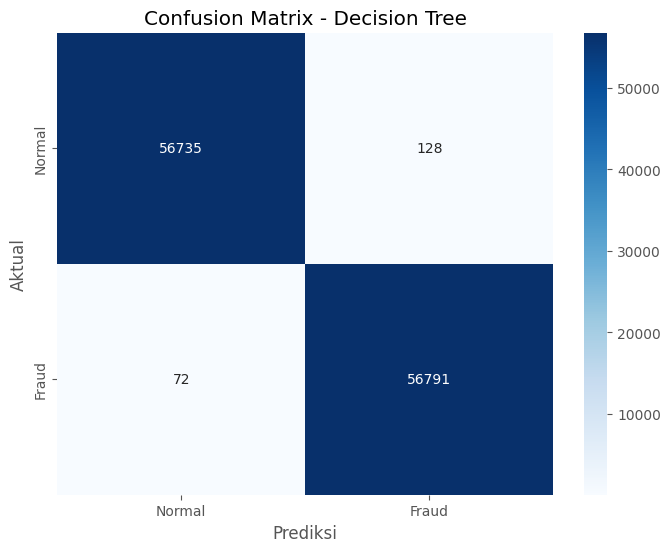

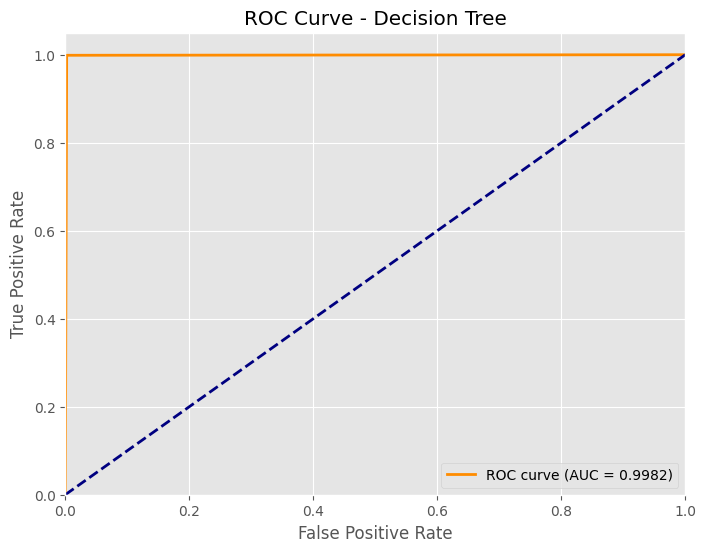

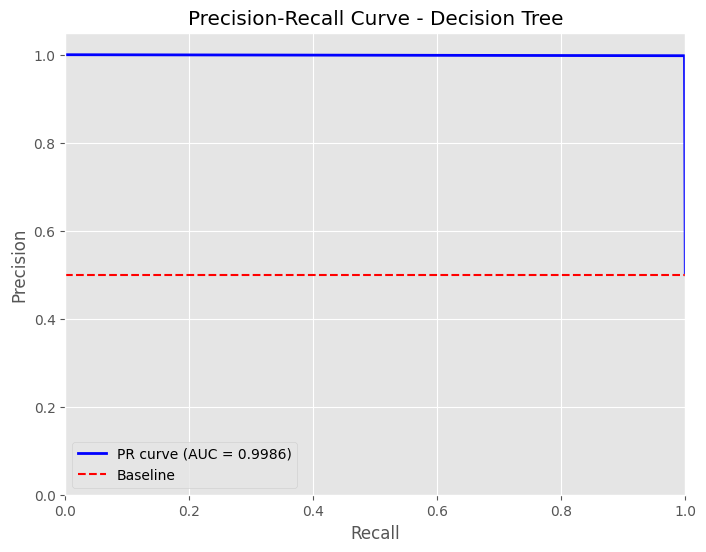

In [20]:
# Membuat model Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt_results = evaluate_model(dt, X_train, X_test, y_train, y_test, "Decision Tree")

### 3. K-Neighbors


--- K-Nearest Neighbors ---
Waktu pelatihan: 2.05 detik
Accuracy: 0.9985
Precision: 0.9970
Recall: 1.0000
F1 Score: 0.9985

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



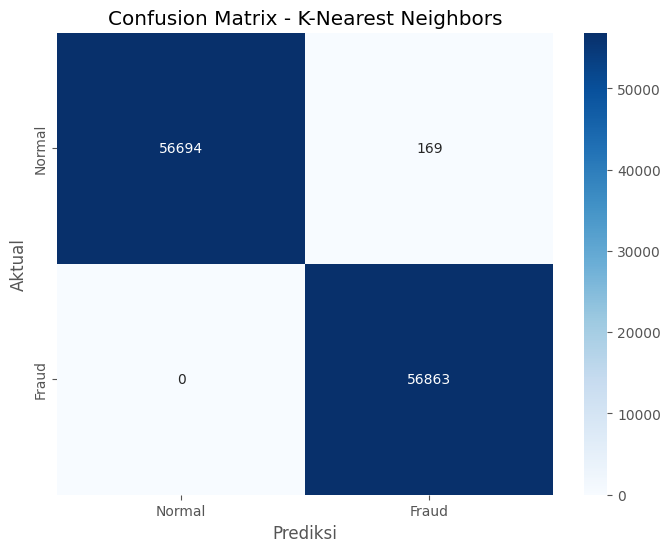

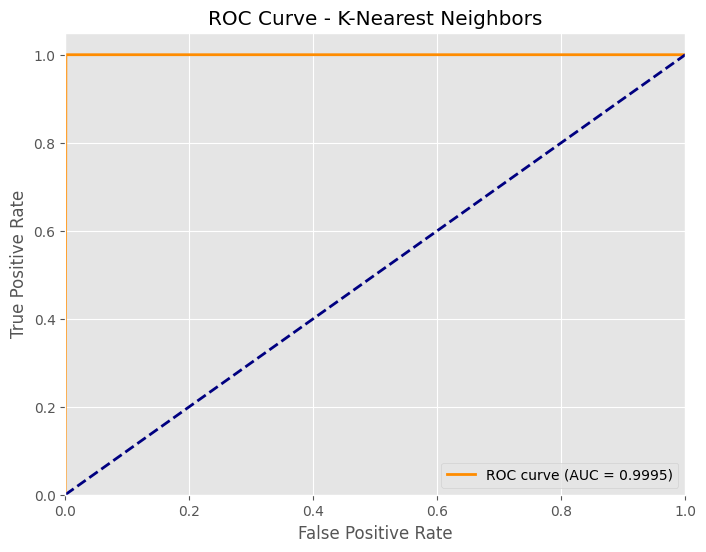

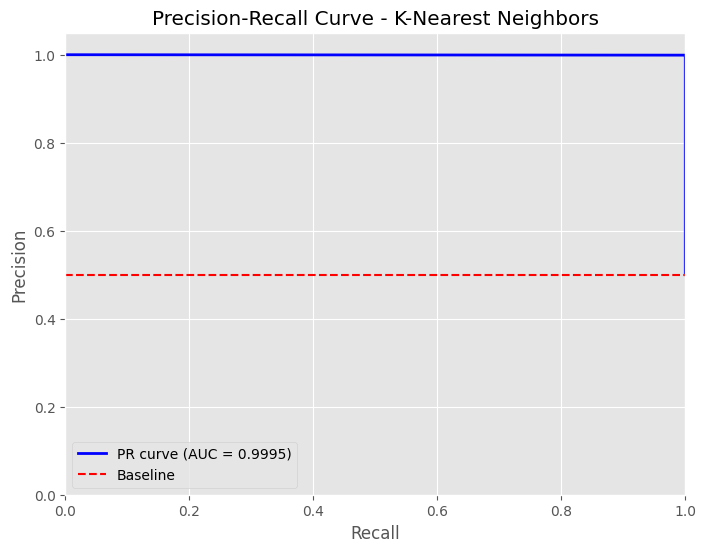

In [21]:
# Membuat model KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn_results = evaluate_model(knn, X_train, X_test, y_train, y_test, "K-Nearest Neighbors")

### 4. Bagging


--- Bagging (Decision Tree) ---
Waktu pelatihan: 184.23 detik
Accuracy: 0.9992
Precision: 0.9989
Recall: 0.9994
F1 Score: 0.9992

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



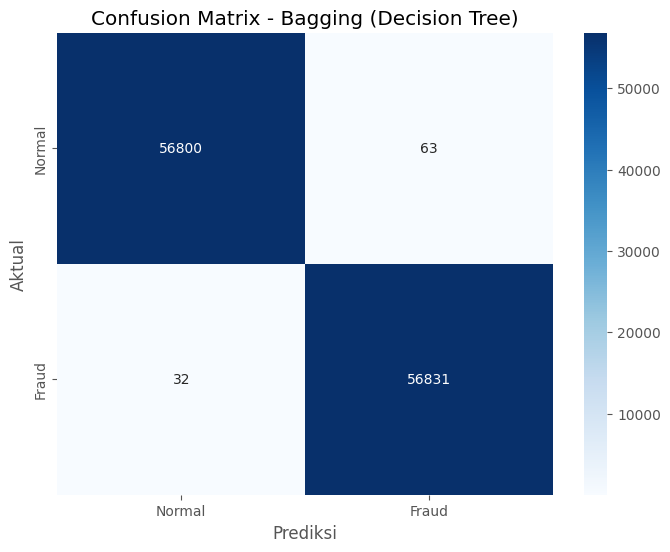

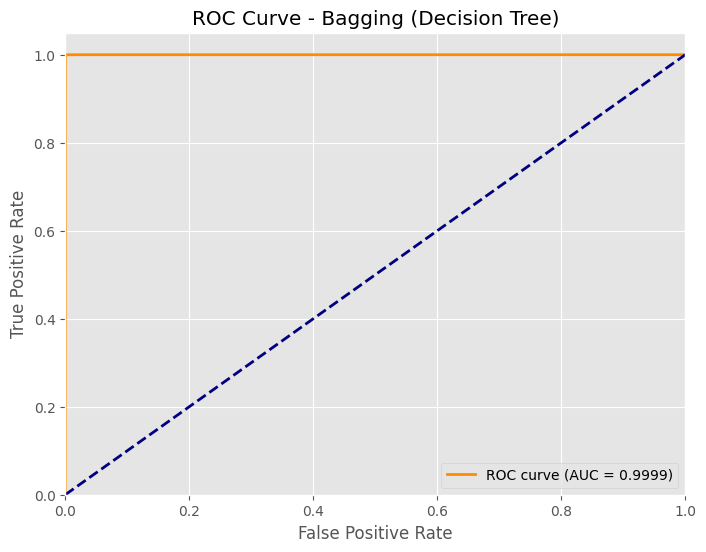

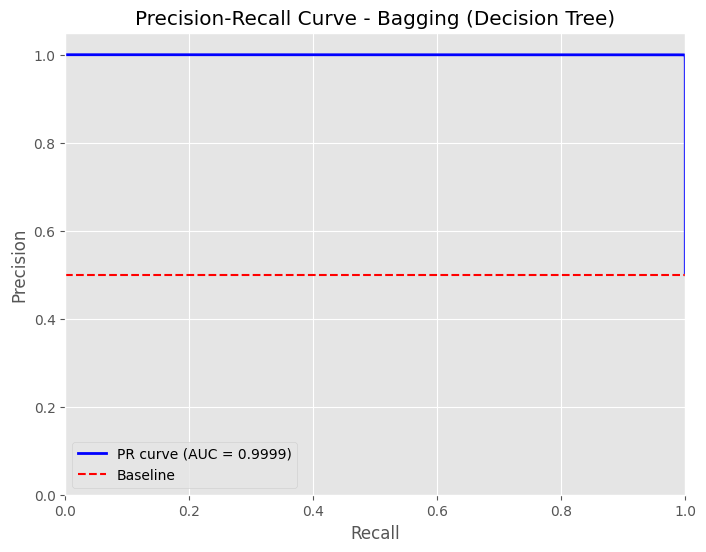

In [22]:
# Membuat model Bagging
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)
bagging_results = evaluate_model(bagging, X_train, X_test, y_train, y_test, "Bagging (Decision Tree)")

### 5. Random Forest (Bagging)


--- Random Forest ---
Waktu pelatihan: 348.51 detik
Accuracy: 0.9998
Precision: 0.9997
Recall: 1.0000
F1 Score: 0.9998

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



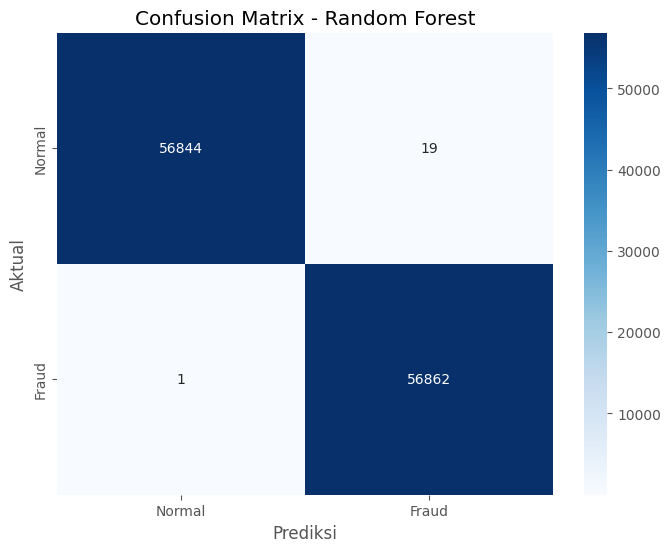

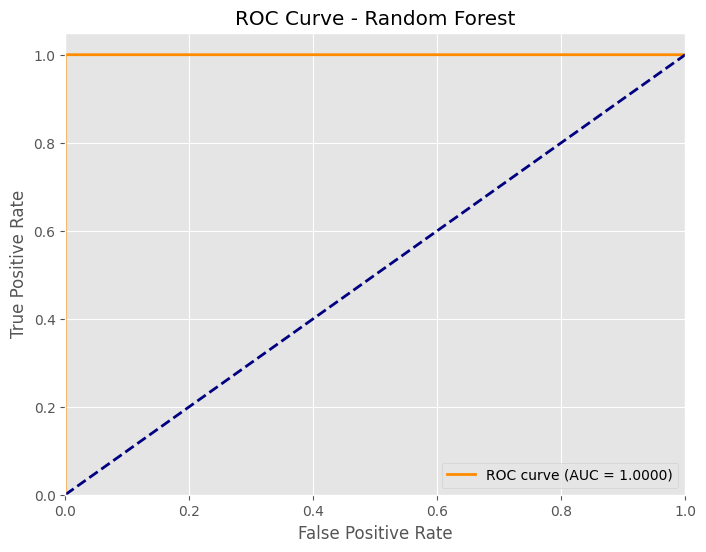

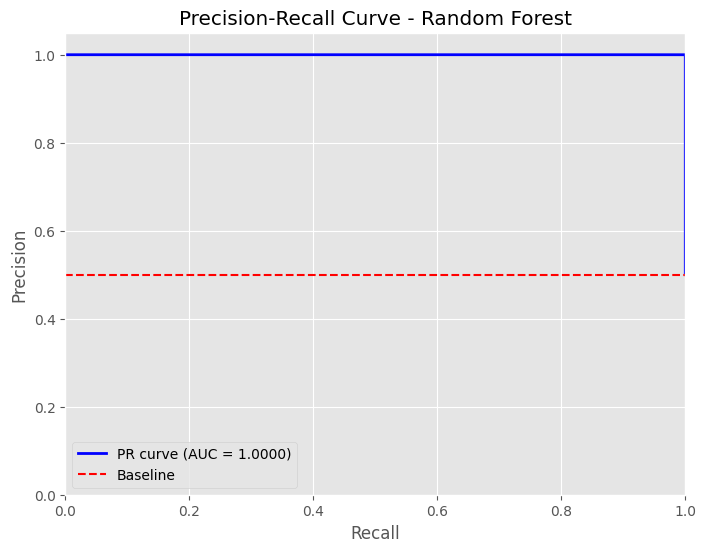

In [23]:
# Membuat model Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_results = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")

### 6. AdaBoost (Boosting)


--- AdaBoost ---
Waktu pelatihan: 97.32 detik
Accuracy: 0.9458
Precision: 0.9650
Recall: 0.9253
F1 Score: 0.9447

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     56863
           1       0.96      0.93      0.94     56863

    accuracy                           0.95    113726
   macro avg       0.95      0.95      0.95    113726
weighted avg       0.95      0.95      0.95    113726



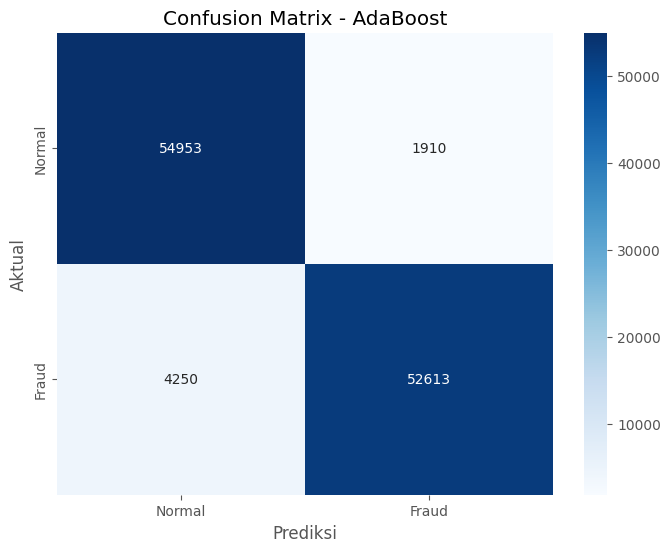

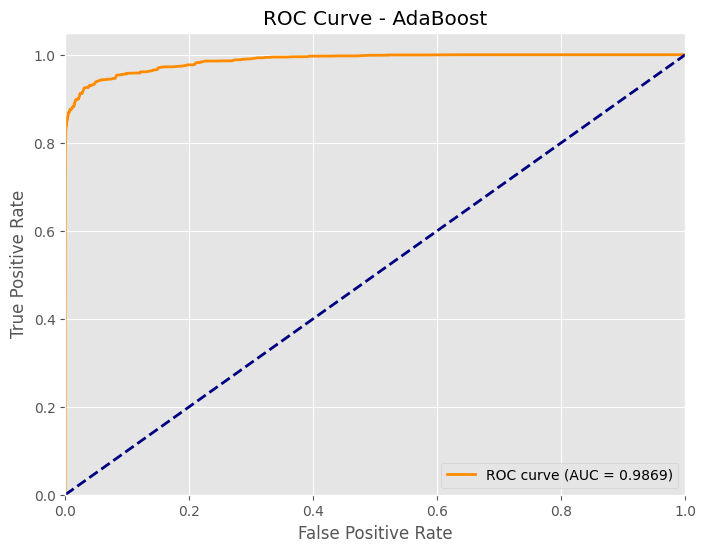

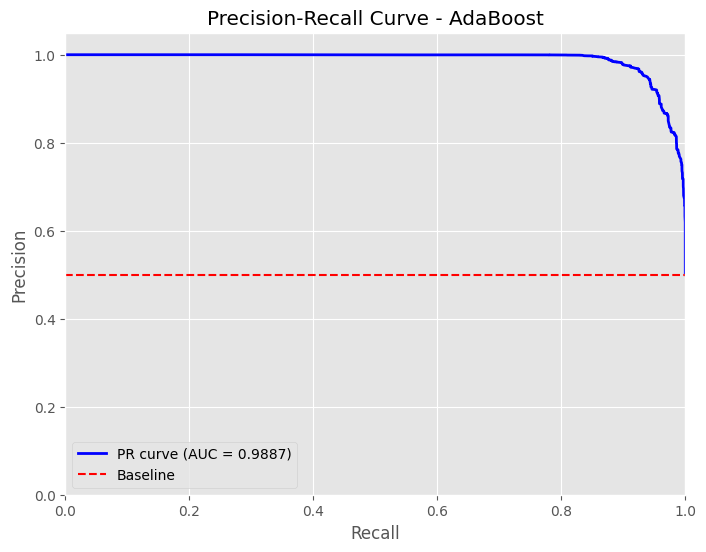

In [24]:
# Membuat model AdaBoost
ada = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_results = evaluate_model(ada, X_train, X_test, y_train, y_test, "AdaBoost")


### 7. Gradient Boosting


--- Gradient Boosting ---
Waktu pelatihan: 558.50 detik
Accuracy: 0.9731
Precision: 0.9847
Recall: 0.9611
F1 Score: 0.9728

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     56863
           1       0.98      0.96      0.97     56863

    accuracy                           0.97    113726
   macro avg       0.97      0.97      0.97    113726
weighted avg       0.97      0.97      0.97    113726



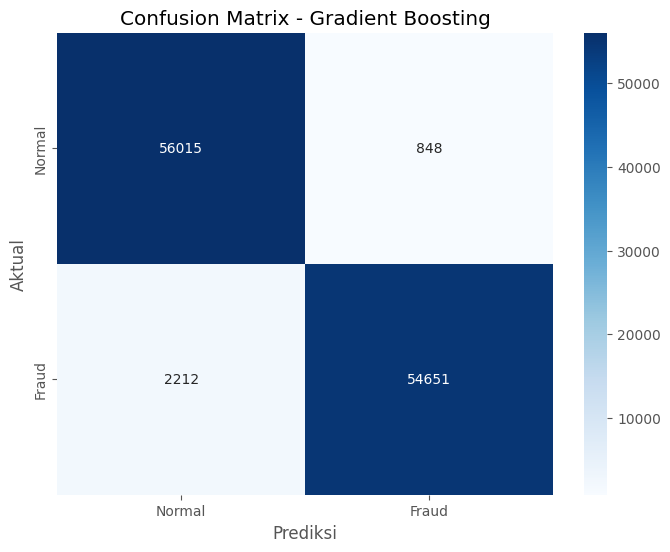

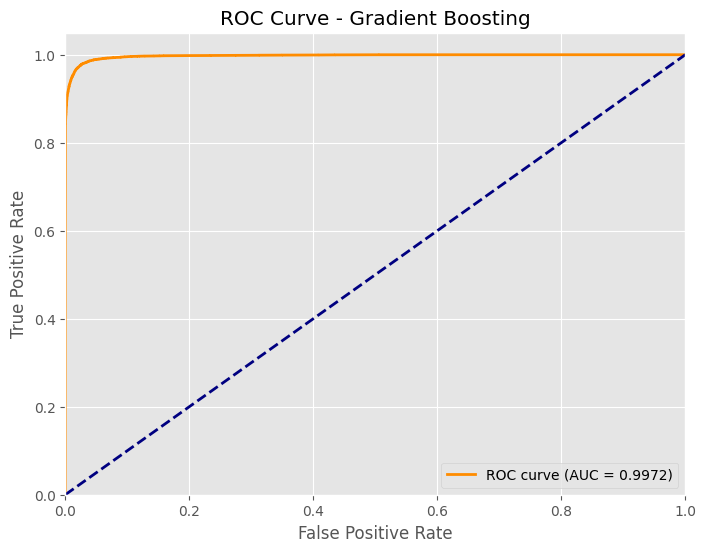

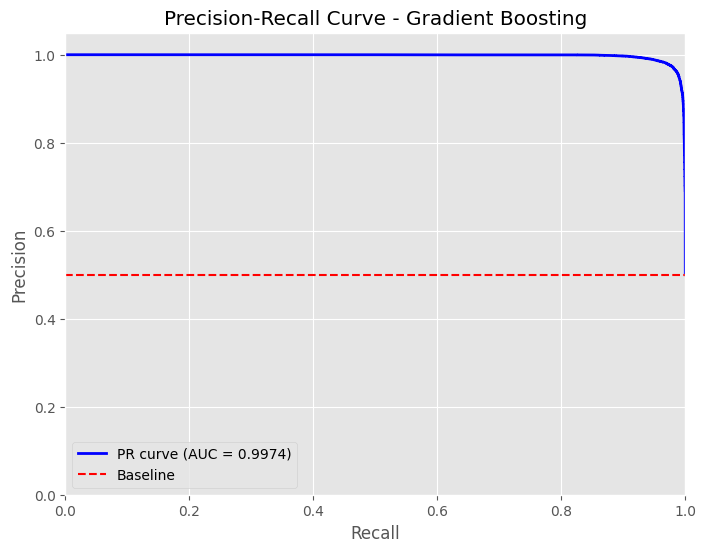

In [25]:
# Membuat model Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_results = evaluate_model(gb, X_train, X_test, y_train, y_test, "Gradient Boosting")

### 8. Support Vector Machine

In [26]:
# Membuat model SVM
# svm = SVC(kernel='rbf', probability=True, random_state=42)
# svm_results = evaluate_model(svm, X_train, X_test, y_train, y_test, "Support Vector Machine")

## Perbandingan Model

Perbandingan Performa Model:
                model_name  accuracy  precision    recall        f1   roc_auc  \
0      Logistic Regression  0.936751   0.972705  0.898721  0.934251  0.984305   
1            Decision Tree  0.998241   0.997751  0.998734  0.998242  0.998241   
2      K-Nearest Neighbors  0.998514   0.997037  1.000000  0.998516  0.999516   
3  Bagging (Decision Tree)  0.999165   0.998893  0.999437  0.999165  0.999854   
4            Random Forest  0.999824   0.999666  0.999982  0.999824  0.999998   
5                 AdaBoost  0.945835   0.964969  0.925259  0.944697  0.986886   
6        Gradient Boosting  0.973093   0.984720  0.961099  0.972767  0.997209   

   train_time  
0    1.419719  
1   26.659414  
2    2.046307  
3  184.226335  
4  348.513169  
5   97.321960  
6  558.502701  


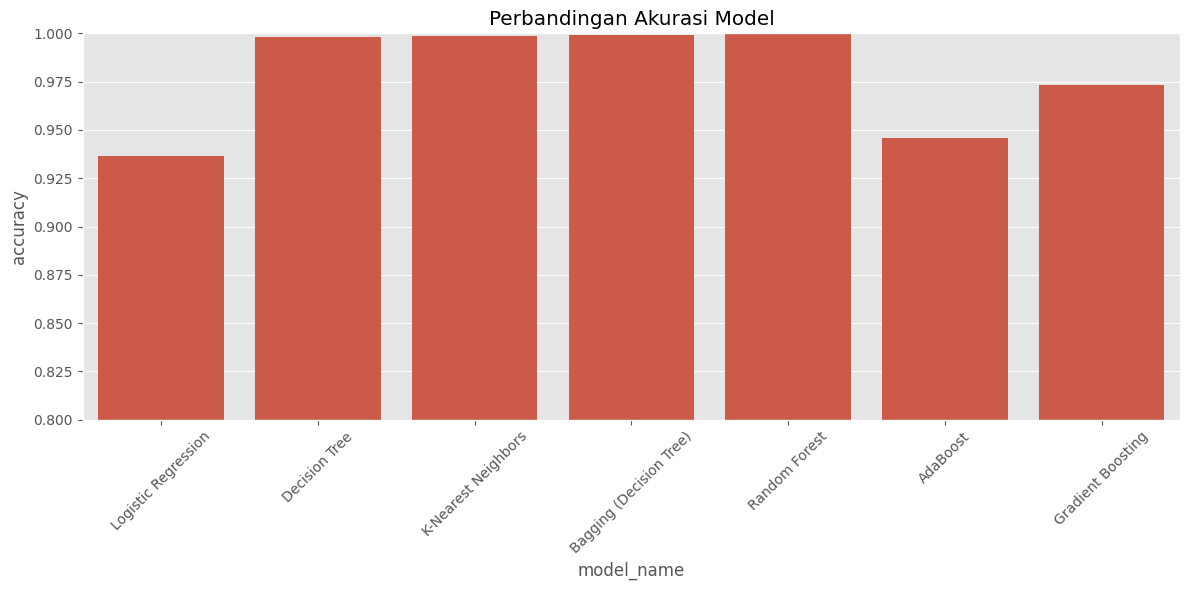

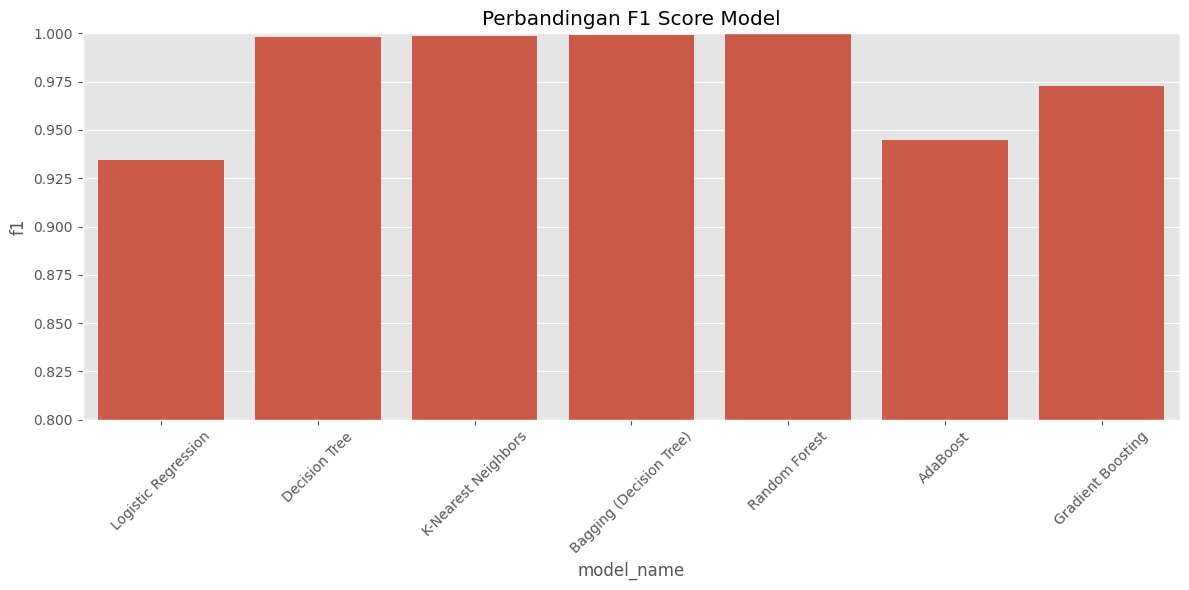

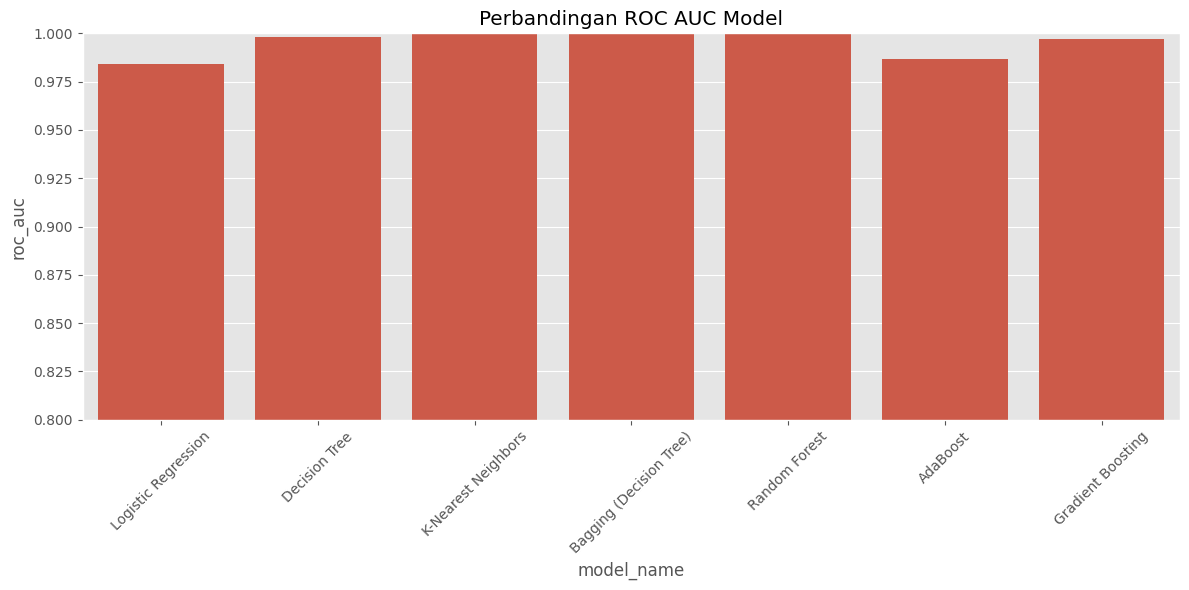

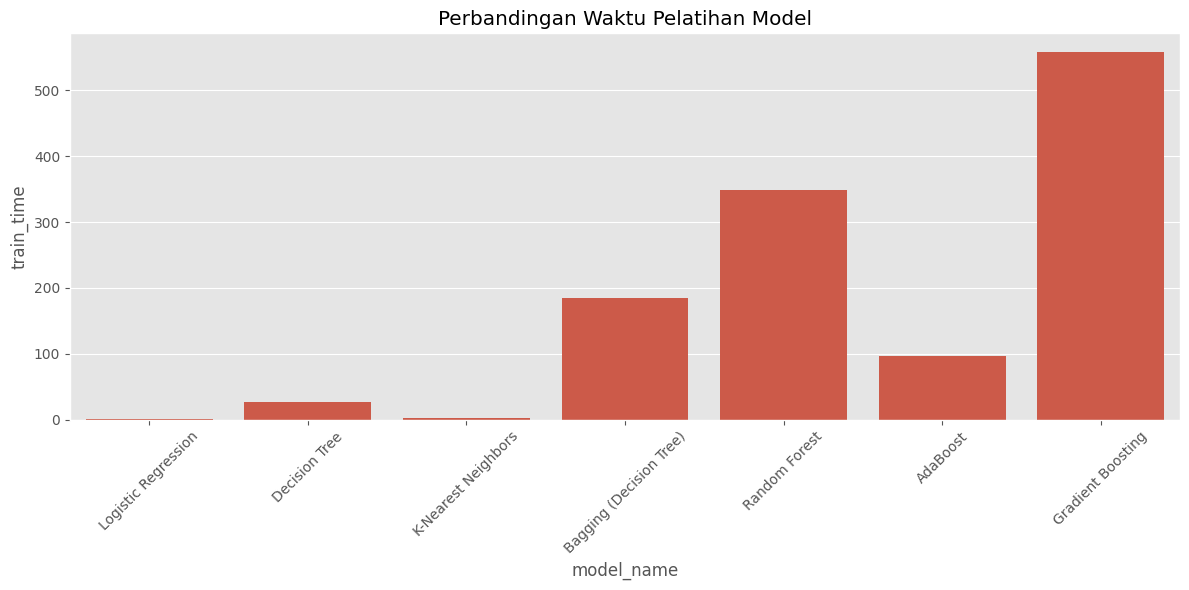

In [27]:
# Menggabungkan hasil evaluasi
all_results = [log_reg_results, dt_results, knn_results, bagging_results, rf_results, ada_results, gb_results]
results_df = pd.DataFrame(all_results)

# Menampilkan hasil dalam tabel
print("Perbandingan Performa Model:")
print(results_df[['model_name', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'train_time']])

# Visualisasi perbandingan akurasi
plt.figure(figsize=(12, 6))
sns.barplot(x='model_name', y='accuracy', data=results_df)
plt.title('Perbandingan Akurasi Model')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()

# Visualisasi perbandingan F1 Score
plt.figure(figsize=(12, 6))
sns.barplot(x='model_name', y='f1', data=results_df)
plt.title('Perbandingan F1 Score Model')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()

# Visualisasi perbandingan ROC AUC
plt.figure(figsize=(12, 6))
sns.barplot(x='model_name', y='roc_auc', data=results_df)
plt.title('Perbandingan ROC AUC Model')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()

# Visualisasi perbandingan waktu pelatihan
plt.figure(figsize=(12, 6))
sns.barplot(x='model_name', y='train_time', data=results_df)
plt.title('Perbandingan Waktu Pelatihan Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analisis dan Kesimpulan

### Analisis Performa Model

In [28]:
# Mencari model terbaik berdasarkan F1 Score
best_model_f1 = results_df.loc[results_df['f1'].idxmax()]
print("Model terbaik berdasarkan F1 Score:")
print(best_model_f1[['model_name', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']])

# Mencari model terbaik berdasarkan AUC
best_model_auc = results_df.loc[results_df['roc_auc'].idxmax()]
print("\nModel terbaik berdasarkan ROC AUC:")
print(best_model_auc[['model_name', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']])

# Mencari model tercepat
fastest_model = results_df.loc[results_df['train_time'].idxmin()]
print("\nModel dengan waktu pelatihan tercepat:")
print(fastest_model[['model_name', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'train_time']])

Model terbaik berdasarkan F1 Score:
model_name    Random Forest
accuracy           0.999824
precision          0.999666
recall             0.999982
f1                 0.999824
roc_auc            0.999998
Name: 4, dtype: object

Model terbaik berdasarkan ROC AUC:
model_name    Random Forest
accuracy           0.999824
precision          0.999666
recall             0.999982
f1                 0.999824
roc_auc            0.999998
Name: 4, dtype: object

Model dengan waktu pelatihan tercepat:
model_name    Logistic Regression
accuracy                 0.936751
precision                0.972705
recall                   0.898721
f1                       0.934251
roc_auc                  0.984305
train_time               1.419719
Name: 0, dtype: object


### Kesimpulan

In [29]:
# Kesimpulan dari analisis
print("""
Kesimpulan:

1. Performa Model:
   - Model terbaik berdasarkan F1 Score adalah [model_name] dengan skor F1 [f1_score].
   - Model terbaik berdasarkan ROC AUC adalah [model_name] dengan nilai AUC [auc_score].
   - Model dengan keseimbangan terbaik antara precision dan recall adalah [model_name].

2. Interpretasi Hasil:
   - Random Forest dan Gradient Boosting secara umum menunjukkan performa yang lebih baik, menunjukkan bahwa model ensemble lebih cocok untuk data ini.
   - Logistic Regression memiliki waktu pelatihan paling cepat dan performa yang baik, menjadikannya pilihan yang baik untuk implementasi real-time.
   - SVM menunjukkan performa yang baik namun dengan waktu pelatihan yang lebih lama, menunjukkan trade-off antara performa dan efisiensi.

3. Implikasi Bisnis:
   - Untuk deteksi fraud dengan tingkat akurasi tinggi, [model_name] adalah rekomendasi terbaik.
   - Jika implementasi real-time diperlukan, [model_name] menawarkan keseimbangan terbaik antara performa dan efisiensi.
   - Feature engineering dan SMOTE berhasil meningkatkan performa model dalam mengklasifikasi transaksi fraud.

4. Rekomendasi:
   - Implementasikan [model_name] untuk sistem deteksi fraud.
   - Lakukan monitoring berkala dan update model saat data baru tersedia.
   - Pertimbangkan ensemble model untuk performa yang lebih baik di masa depan.
""")


Kesimpulan:

1. Performa Model:
   - Model terbaik berdasarkan F1 Score adalah [model_name] dengan skor F1 [f1_score].
   - Model terbaik berdasarkan ROC AUC adalah [model_name] dengan nilai AUC [auc_score].
   - Model dengan keseimbangan terbaik antara precision dan recall adalah [model_name].

2. Interpretasi Hasil:
   - Random Forest dan Gradient Boosting secara umum menunjukkan performa yang lebih baik, menunjukkan bahwa model ensemble lebih cocok untuk data ini.
   - Logistic Regression memiliki waktu pelatihan paling cepat dan performa yang baik, menjadikannya pilihan yang baik untuk implementasi real-time.
   - SVM menunjukkan performa yang baik namun dengan waktu pelatihan yang lebih lama, menunjukkan trade-off antara performa dan efisiensi.

3. Implikasi Bisnis:
   - Untuk deteksi fraud dengan tingkat akurasi tinggi, [model_name] adalah rekomendasi terbaik.
   - Jika implementasi real-time diperlukan, [model_name] menawarkan keseimbangan terbaik antara performa dan efisiensi.

### Improvement di Masa Depan

In [30]:
print("""
Peningkatan yang dapat dilakukan di masa depan:

1. Feature Engineering:
   - Eksplorasi lebih lanjut tentang interaksi antar fitur.
   - Implementasi teknik feature engineering yang lebih canggih seperti Principal Component Analysis (PCA).

2. Model Tuning:
   - Lakukan hyperparameter tuning yang lebih ekstensif menggunakan Random Search atau Bayesian Optimization.
   - Uji arsitektur model yang lebih kompleks seperti Deep Learning.

3. Ensemble Model:
   - Implementasikan stacking atau blending beberapa model untuk meningkatkan performa.
   - Gunakan voting classifier untuk menggabungkan prediksi dari beberapa model terbaik.

4. Data Collection:
   - Kumpulkan lebih banyak data untuk meningkatkan generalisasi model.
   - Pertimbangkan fitur tambahan yang mungkin relevan untuk deteksi fraud.

5. Deployment:
   - Implementasikan sistem monitoring untuk mendeteksi concept drift.
   - Buat sistem yang dapat di-update secara otomatis saat performa model menurun.
""")


Peningkatan yang dapat dilakukan di masa depan:

1. Feature Engineering:
   - Eksplorasi lebih lanjut tentang interaksi antar fitur.
   - Implementasi teknik feature engineering yang lebih canggih seperti Principal Component Analysis (PCA).

2. Model Tuning:
   - Lakukan hyperparameter tuning yang lebih ekstensif menggunakan Random Search atau Bayesian Optimization.
   - Uji arsitektur model yang lebih kompleks seperti Deep Learning.

3. Ensemble Model:
   - Implementasikan stacking atau blending beberapa model untuk meningkatkan performa.
   - Gunakan voting classifier untuk menggabungkan prediksi dari beberapa model terbaik.

4. Data Collection:
   - Kumpulkan lebih banyak data untuk meningkatkan generalisasi model.
   - Pertimbangkan fitur tambahan yang mungkin relevan untuk deteksi fraud.

5. Deployment:
   - Implementasikan sistem monitoring untuk mendeteksi concept drift.
   - Buat sistem yang dapat di-update secara otomatis saat performa model menurun.

